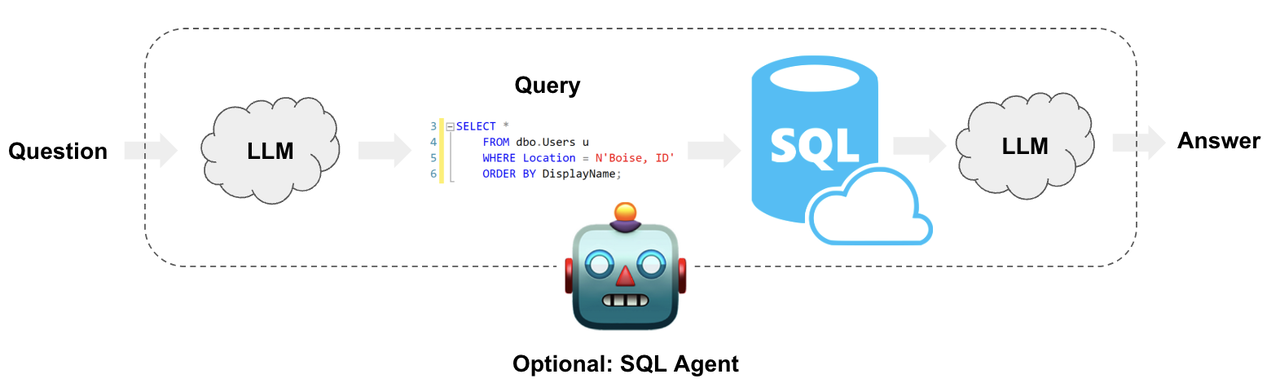

# **Connect the Colab instance to google drive**

In [1]:
#Code to mount Google Drive at Colab Notebook instance
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Install Langchain and Google Gemini related libraries**

In [2]:
!pip install -q -U langchain
!pip install -q -U google-generativeai langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.6/274.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 2.9 MB/s eta 0:00:00


# Get Gemini API Key from Secrets
Set GEMINI_KEY secret key at Google Colab and get that here to runn Google Gemini LLM. You can get Google Gemini Key from following link https://makersuite.google.com/app/apikey

In [3]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GEMINI_KEY')

Copy chinhook.db to your Google Drive

Now, chinhook.db is in our directory and we can interface with it using the SQLAlchemy-driven SQLDatabase class.

Please refer this webiste to understand this project in a deatiled way [Text to SQL using Langchain and LLM](https://python.langchain.com/docs/use_cases/sql/quickstart)

In [4]:
# Let's connect to the database and check the schema
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:////content/drive/MyDrive/Colab Notebooks/chinook.db")
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


In [5]:
# Get the first 10 customers from the Customers table
db.run("SELECT * FROM Customers LIMIT 10;")

"[(1, 'Luís', 'Gonçalves', 'Embraer - Empresa Brasileira de Aeronáutica S.A.', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', '+55 (12) 3923-5555', '+55 (12) 3923-5566', 'luisg@embraer.com.br', 3), (2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'leonekohler@surfeu.de', 5), (3, 'François', 'Tremblay', None, '1498 rue Bélanger', 'Montréal', 'QC', 'Canada', 'H2G 1A7', '+1 (514) 721-4711', None, 'ftremblay@gmail.com', 3), (4, 'Bjørn', 'Hansen', None, 'Ullevålsveien 14', 'Oslo', None, 'Norway', '0171', '+47 22 44 22 22', None, 'bjorn.hansen@yahoo.no', 4), (5, 'František', 'Wichterlová', 'JetBrains s.r.o.', 'Klanova 9/506', 'Prague', None, 'Czech Republic', '14700', '+420 2 4172 5555', '+420 2 4172 5555', 'frantisekw@jetbrains.com', 4), (6, 'Helena', 'Holý', None, 'Rilská 3174/6', 'Prague', None, 'Czech Republic', '14300', '+420 2 4177 0449', None, 'hholy@gmail.com', 5), (7, 'As

 # Chain
Let’s create a simple chain that takes a question, turns it into a SQL query, executes the query, and uses the result to answer the original question.

# Convert question to SQL query
The first step in a SQL chain or agent is to take the user input and convert it to a SQL query. LangChain comes with a built-in chain for this: create_sql_query_chain

In [6]:
from langchain.chains import create_sql_query_chain
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=GOOGLE_API_KEY, convert_system_message_to_human=True, temperature=0.0)
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "How many employees are there"})
response

'```sql\nSELECT COUNT(*) AS "Number of Employees"\nFROM employees;\n```'

In [16]:
# Let's remove irrelevant characters from the SQL code generated which can lead to errors
response.replace("```sql\n","").replace("\n","").replace("```","")

'SELECT COUNT(*) AS "Number of Employees"FROM employees;'

In [17]:
# We get the correct answer after we remove irrelevat chacacters from the SQL code
response = response.replace("```sql\n","").replace("\n","").replace("```","")
db.run(response)

'[(8,)]'

#Execute SQL query
Now that we’ve generated a SQL query, we’ll want to execute it.

We can use the QuerySQLDatabaseTool to easily add query execution to our chain:

In [18]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

execute_query = QuerySQLDataBaseTool(db=db)

write_query = create_sql_query_chain(llm, db)
chain = write_query | execute_query
chain.invoke({"question": "How many employees are there"})

'Error: (sqlite3.OperationalError) near "```sql\nSELECT COUNT(*) AS "Number of Employees"\nFROM employees;\n```": syntax error\n[SQL: ```sql\nSELECT COUNT(*) AS "Number of Employees"\nFROM employees;\n```]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'

In [11]:
# Let's check the original prompt built for Openai's chatgpt model as we are getting error above
chain.get_prompts()[0].pretty_print()

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result

In [19]:
# Modify the prompt as we are using Google Gemini Pro model instead of OpenAI's GPT 3.5 model
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_core.prompts import PromptTemplate

execute_query = QuerySQLDataBaseTool(db=db)

template = '''Given an input question, first create a syntactically correct {dialect} query to run, then look at the results of the query and return the {top_k} answer.Remove all the irrelevant characters like ``` or \n from the sql query to run please and then use that cleaned query to run.
Use the following format:

Question: "Question here"
"SQL Query to run"
SQLResult: "Result of the SQLQuery"
Answer: "Final answer here"

Only use the following tables:

{table_info}.

Question: {input}'''
prompt = PromptTemplate.from_template(template)
prompt
# print(prompt)

write_query = create_sql_query_chain(llm, db, prompt)
# write_query.invoke({"question": "How many employees are there"})
# # print(write_query.invoke({"question": "How many employees are there"}))
chain = write_query | execute_query
chain.invoke({"question": "How many employees are there"})

'[(8,)]'

#Answer the question
Now that we’ve got a way to automatically generate and execute queries, we just need to combine the original question and SQL query result to generate a final answer.

In [20]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, and SQL result, answer the user question.

Question: {question}
{query}
SQL Result: {result}
Answer: """
)

answer = answer_prompt | llm | StrOutputParser()
chain = (
    RunnablePassthrough.assign(query=write_query).assign(
        result=itemgetter("query") | execute_query
    )
    | answer
)

chain.invoke({"question": "How many employees are there"})

'There are 8 employees.'